[4. 5. 5. 4. 4. 4. 4. 4. 4. 4. 4. 4. 4. 5. 4. 5. 4. 4. 5. 4. 4. 5. 4. 5.
 4. 5. 4. 4. 5. 4. 4. 4. 4. 4. 4. 5. 4. 5. 4. 4. 4. 4. 5. 4. 5. 4. 4. 4.
 5. 5. 5. 4. 5. 4. 4. 4. 4. 5. 5. 4. 5. 4. 4. 4. 4. 4. 4. 4. 5. 5. 4. 4.
 4. 4. 4. 5. 4. 4. 4. 5. 5. 4. 4. 5. 4. 4. 4. 4. 4. 5. 5. 4. 4. 4. 4. 5.
 4. 4. 5. 4. 4. 5. 5. 4. 5. 5. 5. 5. 4. 4. 4. 5. 4. 4. 4. 4. 5. 5. 5. 4.]


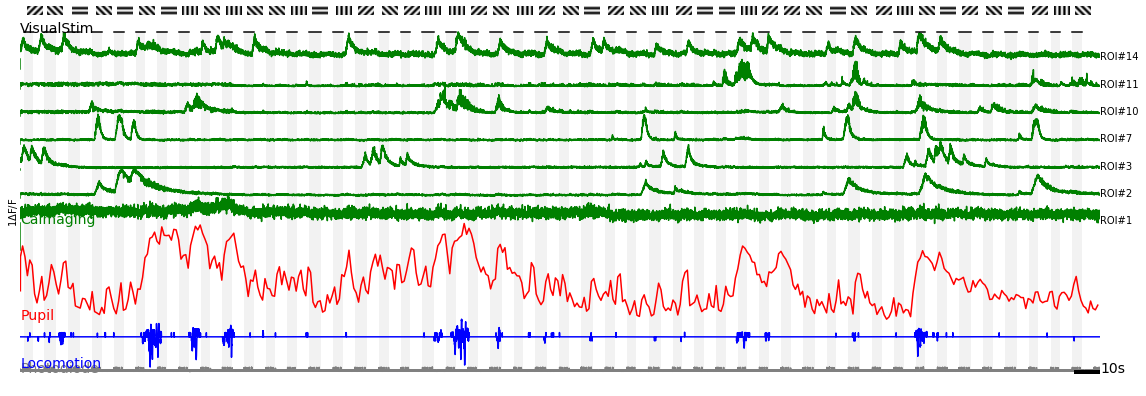

In [7]:
# general modules
import pynwb, os, sys
import numpy as np
import matplotlib.pylab as plt

# custom modules
sys.path.append('..')
from physion.dataviz import plots
from physion.analysis.read_NWB import read as read_NWB
from physion.dataviz.tools import *

from physion.visual_stim.psychopy_code.stimuli import build_stim

# we define a data object fitting this analysis purpose
class Data:
    
    def __init__(self, filename, verbose=False):
        """ opens data file """
        read_NWB(self, filename, verbose=verbose)
        self.metadata['load_from_protocol_data'], self.metadata['no-window'] = True, True
        self.visual_stim = build_stim(self.metadata, no_psychopy=True)
        
    def add_Photodiode(self, tlim, ax,
                       fig_fraction_start=0., fig_fraction=1., subsampling=10, color='grey'):
        i1, i2 = convert_times_to_indices(*tlim, self.nwbfile.acquisition['Photodiode-Signal'])
        x = convert_index_to_time(range(i1,i2), self.nwbfile.acquisition['Photodiode-Signal'])[::subsampling]
        y = self.nwbfile.acquisition['Photodiode-Signal'].data[i1:i2][::subsampling]
        ax.plot(x, (y-y.min())/(y.max()-y.min())*fig_fraction+fig_fraction_start, color=color)
        
    def add_Locomotion(self, tlim, ax,
                       fig_fraction_start=0., fig_fraction=1., subsampling=10, color='red'):
        i1, i2 = convert_times_to_indices(*tlim, self.nwbfile.acquisition['Running-Speed'])
        x = convert_index_to_time(range(i1,i2), self.nwbfile.acquisition['Running-Speed'])[::subsampling]
        y = self.nwbfile.acquisition['Running-Speed'].data[i1:i2][::subsampling]
        ax.plot(x, (y-y.min())/(y.max()-y.min())*fig_fraction+fig_fraction_start, color=color)
        
    def add_Pupil(self, tlim, ax,
                  fig_fraction_start=0., fig_fraction=1., subsampling=1, color='red'):
        i1, i2 = convert_times_to_indices(*tlim, self.nwbfile.processing['Pupil'].data_interfaces['cx'])
        t = self.nwbfile.processing['Pupil'].data_interfaces['sx'].timestamps[i1:i2]
        diameter = self.nwbfile.processing['Pupil'].data_interfaces['sx'].data[i1:i2]*\
                               self.nwbfile.processing['Pupil'].data_interfaces['sy'].data[i1:i2]
        x, y = t[::subsampling], diameter[::subsampling]
        ax.plot(x, (y-y.min())/(y.max()-y.min())*fig_fraction+fig_fraction_start, color=color)
    
    def add_CaImaging(self, tlim, ax,
                      fig_fraction_start=0., fig_fraction=1., color='green',
                      quantity='CaImaging', subquantity='Fluorescence', roiIndices=[0]):
        i1 = convert_time_to_index(tlim[0], self.Neuropil, axis=1)
        i2 = convert_time_to_index(tlim[1], self.Neuropil, axis=1)
        tt = self.Neuropil.timestamps[np.arange(i1,i2)]
        for n, ir in enumerate(roiIndices):
            y = compute_CaImaging_trace(self, subquantity, np.arange(i1,i2), [ir], sum=True)
            ax.plot(tt, (y-y.min())/(y.max()-y.min())*fig_fraction/len(roiIndices)+\
                    n*fig_fraction/len(roiIndices)+fig_fraction_start, color=color)
            ax.plot(tlim[0]*np.ones(2), np.arange(2)*(1.-y.min())/(y.max()-y.min())*fig_fraction/len(roiIndices)+\
                    n*fig_fraction/len(roiIndices)+fig_fraction_start, color=color)
            ax.annotate('ROI#%i'%(ir+1), (tlim[1], n*fig_fraction/len(roiIndices)+fig_fraction_start))
        ax.annotate('1$\Delta$F/F', (tlim[0], fig_fraction_start), ha='right', rotation=90)
        
    def add_VisualStim(self, tlim, ax,
                       fig_fraction_start=0., fig_fraction=1., size=.1, color='k'):
        cond = (self.nwbfile.stimulus['time_start_realigned'].data[:]>tlim[0]) &\
            (self.nwbfile.stimulus['time_stop_realigned'].data[:]<tlim[1])
        ylevel = fig_fraction_start+fig_fraction
        sx, sy = self.visual_stim.screen['resolution']
        for i in np.arange(self.nwbfile.stimulus['time_start_realigned'].num_samples)[cond]:
            tstart = self.nwbfile.stimulus['time_start_realigned'].data[i]
            tstop = self.nwbfile.stimulus['time_stop_realigned'].data[i]
            ax.plot([tstart, tstop], [ylevel, ylevel], color=color)
            ax.fill_between([tstart, tstop], [0,0], np.zeros(2)+ylevel, lw=0, alpha=0.05, color=color)
            axi = plt.axes([(tstart-tlim[0])/(tlim[1]-tlim[0]), 0.99, size,size])#size*sx/sy, size])
            self.visual_stim.show_frame(i, ax=axi,label=None)
            
    
    def show_sample(self, 
                    tlim=[0,100],
                    settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                              'Locomotion':dict(fig_fraction=1, subsampling=10, color='b'),
                              'Pupil':dict(fig_fraction=2, subsampling=10, color='red'),
                              'CaImaging':dict(fig_fraction=4, 
                                    quantity='CaImaging', subquantity='Fluorescence', color='green',
                                               roiIndices=[2, 6, 9, 10, 13, 15, 16, 17, 38, 41]),
                              'VisualStim':dict(fig_fraction=0, size=0.02, color='black')},                    
                    figsize=(15,6), Tbar=20,
                    ax=None):
        if ax is None:
            fig, ax = plt.subplots(1, figsize=(15,6))
        fig_fraction_full, fstart = np.sum([settings[key]['fig_fraction'] for key in settings]), 0
        for key in settings:
            settings[key]['fig_fraction_start'] = fstart
            settings[key]['fig_fraction'] = settings[key]['fig_fraction']/fig_fraction_full
            fstart += settings[key]['fig_fraction']
        for key in settings:
            getattr(self, 'add_%s' % key)(tlim, ax, **settings[key])
            ax.annotate(key, (tlim[0], settings[key]['fig_fraction_start']), 
                        color=settings[key]['color'], fontsize=14)
        ax.axis('off')
        ax.set_xlim(tlim)
        ax.plot([tlim[1]-Tbar, tlim[1]], [0,0], lw=4, color='k')
        ax.annotate(str(Tbar)+'s', [tlim[1], 0], color='k', fontsize=14)
        
        
fig, ax = plt.subplots(1, figsize=(15,6))   
plt.subplots_adjust(left=0, right=1., top=.99)


FILENAMES = os.listdir(os.path.join(os.path.expanduser('~'), 'DATA', 'NDNF+'))
filename = os.path.join(os.path.expanduser('~'), 'DATA', 'NDNF+', FILENAMES[0])
                       
data = Data(filename)
data.show_sample([0, 450], 
                 settings={'Photodiode':dict(fig_fraction=.1, subsampling=10, color='grey'),
                           'Locomotion':dict(fig_fraction=1, subsampling=10, color='b'),
                           'Pupil':dict(fig_fraction=2, subsampling=10, color='red'),
                           'CaImaging':dict(fig_fraction=4, 
                                    quantity='CaImaging', subquantity='Fluorescence', color='green',
                                               roiIndices=[0, 1, 2, 6, 9, 10, 13]),
                           'VisualStim':dict(fig_fraction=0, size=0.02, color='black')},                    
                  ax=ax, Tbar=10)
#fig.savefig('/home/yann/Desktop/data2/raw-data-4.svg')

NameError: name 'os' is not defined